In [1]:
import networkx as nx
import numpy as np
from walkers import Simulation
import random
random.seed(10)

In [2]:
def sample_ER(N, p):
    rd = np.random.rand(N,N)
    A = np.triu(rd < (p))
    np.fill_diagonal(A, 0)
    return A
    
def gen_com_graph(N, n_coms, p_high, p_low):
    N_pc = int(N / n_coms)
    A_struct = np.zeros((N,N))
    for i in range(n_coms):
        A_struct[i*N_pc:(i+1)*N_pc, i*N_pc:(i+1)*N_pc] = sample_ER(N_pc, p_high)
    A_random = sample_ER(N, p_low)
    A = A_struct + A_random
    

    return nx.from_numpy_matrix(A), A_struct, A_random

In [3]:
G, _, _ = gen_com_graph(30, 2, 0.3, 0.02)

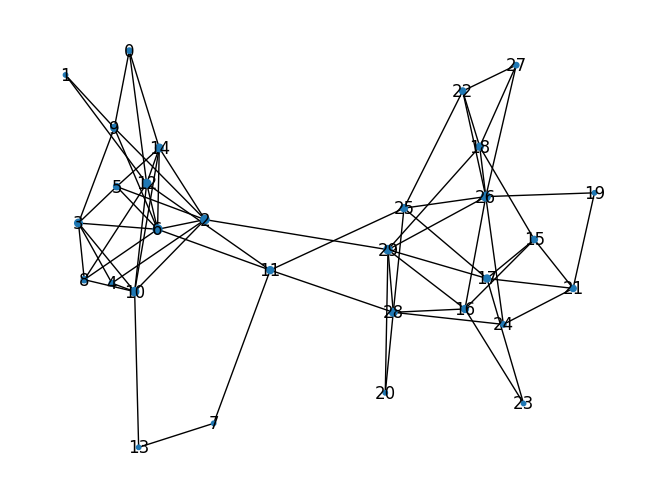

In [4]:
d = dict(G.degree)
nx.draw(G, nodelist=d.keys(), node_size=[v * 5 for v in d.values()], with_labels=True)

In [5]:
# all walkers start at node 10
sim1 = Simulation(10000, G, 0.1, 200, 10)
sim1.run(1.0)

IndexError: list index out of range

In [7]:
# all walkers start at random nodes (uniformly distributed)
sim2 = Simulation(10000, G, 0.1, 200)
sim2.run()


In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

Text(0, 0.5, 'Fraction of walkers')

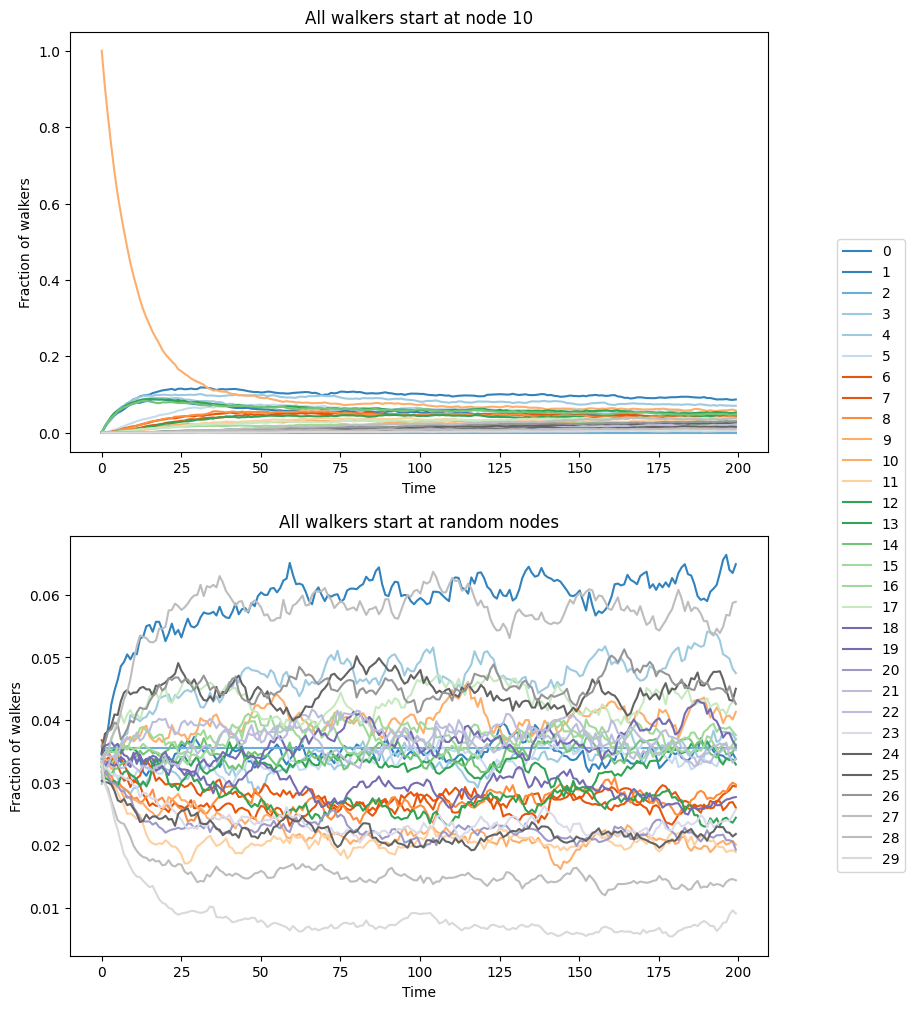

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 12))

jet = cm = plt.get_cmap('tab20c') 
cNorm  = colors.Normalize(vmin=0, vmax=sim2.G.number_of_nodes())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(0, sim1.G.number_of_nodes(), 1):
    color_val = scalarMap.to_rgba(i)
    ax1.plot(sim1.timeline, sim1.node_log[:,i]/sim1.n_walkers, label=i, color=color_val)

ax1.set_title('All walkers start at node 10')
ax1.set_xlabel('Time')
ax1.set_ylabel('Fraction of walkers')

for i in range(0, sim2.G.number_of_nodes(), 1):
    color_val = scalarMap.to_rgba(i)
    ax2.plot(sim2.timeline, sim2.node_log[:,i]/sim2.n_walkers, label=i, color=color_val)

ax1.legend(np.linspace(0, sim1.G.number_of_nodes()-1, sim1.G.number_of_nodes(), dtype=int), loc=(1.1, -1))
ax2.set_title('All walkers start at random nodes')
ax2.set_xlabel('Time')
ax2.set_ylabel('Fraction of walkers')

